In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## Image Preprocessing
- ### split the provided training set in 85% for actual training set and 15% to be used as validation set

In [3]:
SEED = 1849
image_size = (256, 256)
class_names=['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']
num_classes = len(class_names)

train_ds = keras.preprocessing.image_dataset_from_directory(
    directory="dataset/train",
    color_mode="grayscale",
    class_names=class_names,
    validation_split=0.15,
    subset="training",
    shuffle=True,
    seed=SEED,
    image_size=image_size,
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    directory="dataset/train",
    color_mode="grayscale",
    class_names=class_names,
    validation_split=0.15,
    subset="validation",
    shuffle=True,
    seed=SEED,
    image_size=image_size,
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    directory="dataset/test",
    color_mode="grayscale",
    class_names=class_names,
    validation_split=None,
    subset=None,
    shuffle=True,
    seed=SEED,
    image_size=image_size,
)

Found 1500 files belonging to 15 classes.
Using 1275 files for training.
Found 1500 files belonging to 15 classes.
Using 225 files for validation.
Found 2985 files belonging to 15 classes.


## Data Augmentation of the training set
- ### left-to-right reflection
- ### random crop (cropping a patch of 128 x 128)
- ### random rotation
- ### resizing of the image (64 x 64)

In [4]:
IMG_SIZE = 64
CROP_SIZE = 128

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal", seed=SEED),
        layers.experimental.preprocessing.RandomCrop(height=CROP_SIZE, width=CROP_SIZE, seed=SEED),
        layers.experimental.preprocessing.RandomRotation(factor=0.1, seed=SEED),
        layers.experimental.preprocessing.Resizing(height=IMG_SIZE, width=IMG_SIZE)
    ]
)

data_resizing = keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(height=IMG_SIZE, width=IMG_SIZE)
    ]
)

## Let's see a sample artificially augmented

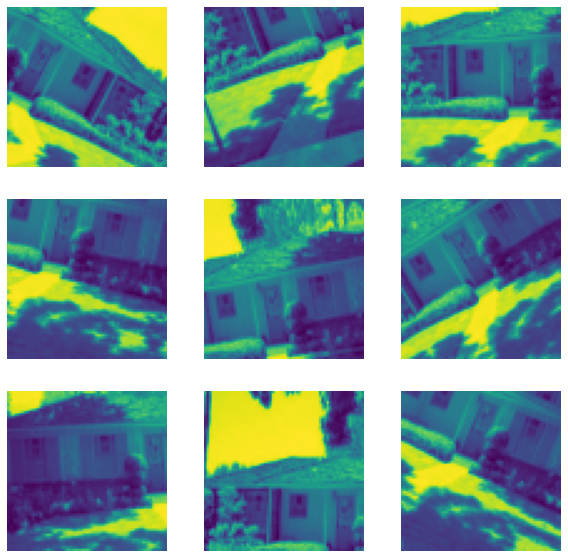

In [5]:
plt.figure(figsize=(10, 10))
for image, _ in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augmentation(image)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")

## Actual data augmentation

In [6]:
augmented_training_dataset = train_ds.map(lambda x, y: (data_augmentation(x), y))
resized_training_dataset = train_ds.map(lambda x, y: (data_resizing(x), y))

validation_dataset = val_ds.map(lambda x, y: (data_resizing(x), y))
test_dataset = test_ds.map(lambda x, y: (data_resizing(x), y))

In [7]:
training_dataset = augmented_training_dataset.concatenate(resized_training_dataset)

## Layout of the improved CNN
- ### initial weights drawn from a Gaussian distribution with a mean of 0 and a standard deviation of 0.01
- ### initial bias values to 0
- ### employ the "Adam" optimizer using minibatches of size 32

| Type    | Size |
| ----------- | ----------- |
| Image Input   | 64×64×1 images|
| Convolution   | 8 3×3 convolutions with stride 1        |
| Dropout   |  |
| Batch Normalization   |  |
| ReLU   |         |
| Max Pooling   | 2×2 max pooling with stride 2        |
| Convolution   | 16 5×5 convolutions with stride 1        |
| Dropout   |  |
| Batch Normalization   |  |
| ReLU   |         |
| Max Pooling   | 2×2 max pooling with stride 2        |
| Convolution   | 32 7×7 convolutions with stride 1        |
| Dropout   |  |
| Batch Normalization   |  |
| ReLU   |         |
| Fully Connected   | 15        |
| Softmax   | softmax        |
| Classification Output   | crossentropyex        |

## BUILDING the improved CNN model


In [8]:
bias_init = initializers.Zeros()
weight_init = initializers.RandomNormal(mean=0, stddev=0.01)

model = keras.Sequential()

model.add(layers.InputLayer(input_shape=(64,64,1)))
model.add(layers.Conv2D(filters=8, kernel_size=(3,3), strides=1, bias_initializer=bias_init,kernel_initializer=weight_init))

model.add(layers.BatchNormalization())

model.add(layers.Activation(activations.relu))

model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(layers.Conv2D(filters=16, kernel_size=(5,5), strides=1, bias_initializer=bias_init,kernel_initializer=weight_init))

model.add(layers.BatchNormalization())

model.add(layers.Activation(activations.relu))

model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(layers.Conv2D(filters=32, kernel_size=(7,7), strides=1, bias_initializer=bias_init,kernel_initializer=weight_init))

model.add(layers.BatchNormalization())

model.add(layers.Activation(activations.relu))

model.add(layers.Flatten())

model.add(layers.Dropout(rate=0.5, seed=SEED))
model.add(layers.Dense(units=num_classes, bias_initializer=bias_init, kernel_initializer=weight_init))

model.add(layers.Softmax())

In [9]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 62, 62, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 16)        3216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 27, 27, 16)       

## Compiling the model with SGD optimizer and crossentropy loss

In [10]:
opt = optimizers.Adam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [11]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

minibatches = 32
epochs = 100

history = model.fit(training_dataset, validation_data=validation_dataset, batch_size=minibatches, epochs=epochs,
callbacks=[early_stopping], shuffle=True, verbose=1)

Epoch 1/100
80/80 [==============================] - 6s 72ms/step - loss: 2.6636 - accuracy: 0.1313 - val_loss: 3.0220 - val_accuracy: 0.1378
Epoch 2/100
80/80 [==============================] - 5s 66ms/step - loss: 2.5221 - accuracy: 0.1910 - val_loss: 2.5571 - val_accuracy: 0.1867
Epoch 3/100
80/80 [==============================] - 5s 64ms/step - loss: 2.3687 - accuracy: 0.2295 - val_loss: 2.0353 - val_accuracy: 0.3778
Epoch 4/100
80/80 [==============================] - 5s 63ms/step - loss: 2.2394 - accuracy: 0.2736 - val_loss: 1.7535 - val_accuracy: 0.4489
Epoch 5/100
80/80 [==============================] - 5s 63ms/step - loss: 2.2080 - accuracy: 0.2901 - val_loss: 1.7992 - val_accuracy: 0.4489
Epoch 6/100
80/80 [==============================] - 5s 63ms/step - loss: 2.1179 - accuracy: 0.3107 - val_loss: 3.3314 - val_accuracy: 0.2533
Epoch 7/100
80/80 [==============================] - 5s 63ms/step - loss: 2.0279 - accuracy: 0.3418 - val_loss: 2.3047 - val_accuracy: 0.3556
Epoch 

In [12]:
test_eval = model.evaluate(test_dataset, verbose=0)
print('Overall Test accuracy: {number:.{digits}f}'.format(number=test_eval[1], digits=2))

Overall Test accuracy: 0.60


## Ensamble of 5 CNN

In [26]:
def build_model():
    bias_init = initializers.Zeros()
    weight_init = initializers.RandomNormal(mean=0, stddev=0.01)

    model = keras.Sequential()

    model.add(layers.InputLayer(input_shape=(64,64,1)))
    model.add(layers.Conv2D(filters=8, kernel_size=(3,3), strides=1, bias_initializer=bias_init,kernel_initializer=weight_init))

    model.add(layers.BatchNormalization())

    model.add(layers.Activation(activations.relu))

    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(layers.Conv2D(filters=16, kernel_size=(5,5), strides=1, bias_initializer=bias_init,kernel_initializer=weight_init))

    model.add(layers.BatchNormalization())

    model.add(layers.Activation(activations.relu))

    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(layers.Conv2D(filters=32, kernel_size=(7,7), strides=1, bias_initializer=bias_init,kernel_initializer=weight_init))

    model.add(layers.BatchNormalization())

    model.add(layers.Activation(activations.relu))

    model.add(layers.Flatten())

    model.add(layers.Dropout(rate=0.5, seed=SEED))
    model.add(layers.Dense(units=num_classes, bias_initializer=bias_init, kernel_initializer=weight_init))

    model.add(layers.Softmax())

    return model

In [27]:
def compile_model(model):
    opt = optimizers.Adam()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
    return model

In [28]:
def build_and_compile():
    return compile_model(build_model())

In [29]:
def fit_model(model):
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10,restore_best_weights=True)

    minibatches = 32
    epochs = 50

    history = model.fit(training_dataset, validation_data=validation_dataset, batch_size=minibatches, epochs=epochs,
    callbacks=[early_stopping], shuffle=True, verbose=0)

    return history

In [31]:
n_members = 5
models = list()

for member in range(n_members):
    # define and fit model
    model = build_and_compile()
    print("fitting model " + str(member) + "...")
    history = fit_model(model)

    test_eval = model.evaluate(test_dataset, verbose=0)
    print('Overall Test accuracy of current model : {number:.{digits}f}'.format(number=test_eval[1], digits=2))

    # store model in memory as ensemble member
    models.append(model)

fitting model 0...
Overall Test accuracy of current model : 0.54
fitting model 1...
Overall Test accuracy of current model : 0.61
fitting model 2...
Overall Test accuracy of current model : 0.62
fitting model 3...
Overall Test accuracy of current model : 0.60
fitting model 4...
Overall Test accuracy of current model : 0.62


## Retrieve the predictions to compute the overall accuracy of the ensemble of networks

In [149]:
import numpy as np

predictions = list()
test_labels = np.concatenate([y for x, y in test_dataset], axis=0) 

for model in models:
	prediction = np.array([])
	for x, y in test_dataset:
		prediction = np.concatenate([prediction, np.argmax(model.predict(x), axis = -1)])
	predictions.append(prediction)

In [177]:
test_labels = list()
predictions = [[] for x in range(n_members)] #empty list of lists -> [[],[],[]...]

for x, y in test_dataset:
	test_labels.append(y)
	
	for index, model in enumerate(models):
		predictions[index] = np.concatenate([predictions[index], np.argmax(model.predict(x), axis = -1)])

test_labels = np.concatenate(test_labels, axis=-1)

In [178]:
stacked_predictions = np.array(predictions)
average_predictions = np.around(np.average(stacked_predictions, axis=0))

In [183]:
print("Predictions of each network:")
print(stacked_predictions)

print("\n Test_labels:")
print(test_labels)

print("\n Average predictions:")
print(average_predictions)

Predictions of each network:
[[ 2.  1.  5. ...  5.  1.  1.]
 [ 2. 10.  4. ...  7.  1.  1.]
 [ 2.  1.  5. ...  4.  1.  1.]
 [ 2. 10. 11. ... 11.  1.  1.]
 [ 8.  1.  5. ... 13.  1.  1.]]

 Test_labels:
[ 2 10  5 ... 11  1 10]

 Average predictions:
[3. 5. 6. ... 8. 1. 1.]


In [184]:
print('Number of test images correctly labeled by the ensamble of networks: {}/{}'.format((test_labels == average_predictions).sum(), len(test_labels)))

Number of test images correctly labeled by the ensamble of networks: 1235/2985


In [185]:
accuracy = (test_labels == average_predictions).mean()
print("Test accuracy of the ensamble of networks: " + str(accuracy))

Test accuracy of the ensamble of networks: 0.4137353433835846


## Comment on significant changes after the application of the previous modifications
As we can see, every single model has an overall test accuracy of 60%.

The ensamble of networks has an accuracy that is lower than the single model accuracy :(

This is a case of "high variance" in the single models: each model correctly predict a set of classes that differs from the set of classes correctly predicted from the other models.

We are combining the predictions from multiple neural network models to reduce the variance of predictions, thus reducing the generalization error.

-> trade off between accuracy and generalization error.